In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-04-09 08:57:13--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.008s  

2021-04-09 08:57:13 (8.63 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



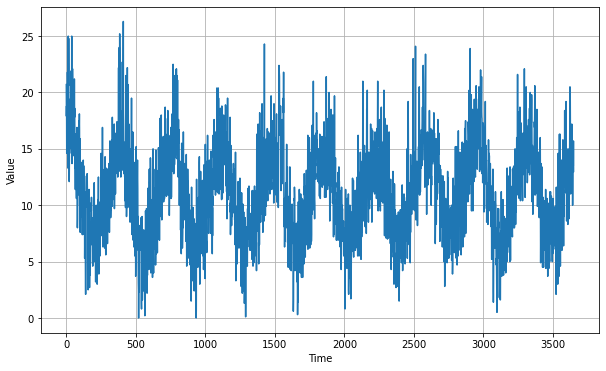

In [14]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  test = csv.reader(csvfile, delimiter=',')
  next(test)
  for i, row in enumerate(test):
    time_step.append(i)
    temps.append(float(row[1]))
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [59]:
split_time = 3000
time_train = time_step[:split_time]
x_train = series[:split_time]
time_valid = time_step[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [60]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # add dimensionality so it fits with RNN
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)

    # define the window and drop rows with incomplete feature
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    
    # shuffle the rows
    ds = ds.shuffle(shuffle_buffer)

    # seperate features and value (last item of row)
    ds = ds.map(lambda w: (w[:-1], w[1:]))

    return ds.batch(batch_size).prefetch(1)

In [61]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [43]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(np.array(x_train).shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation='relu', input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.summary()


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
dense (Dense)                (None, None, 30)          3870      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
____________________

In [44]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 5s 34ms/step - loss: 21.0075 - mae: 21.5054
Epoch 2/100
10/10 [==============================] - 0s 36ms/step - loss: 19.7809 - mae: 20.2786
Epoch 3/100
10/10 [==============================] - 1s 43ms/step - loss: 17.9388 - mae: 18.4360
Epoch 4/100
10/10 [==============================] - 1s 36ms/step - loss: 15.9328 - mae: 16.4294
Epoch 5/100
10/10 [==============================] - 0s 34ms/step - loss: 13.8870 - mae: 14.3828
Epoch 6/100
10/10 [==============================] - 0s 36ms/step - loss: 11.9245 - mae: 12.4186
Epoch 7/100
10/10 [==============================] - 0s 35ms/step - loss: 10.1961 - mae: 10.6884
Epoch 8/100
10/10 [==============================] - 0s 36ms/step - loss: 8.9995 - mae: 9.4900
Epoch 9/100
10/10 [==============================] - 0s 33ms/step - loss: 8.2376 - mae: 8.7257
Epoch 10/100
10/10 [==============================] - 1s 36ms/step - loss: 7.8059 - mae: 8.2911
Epoch 11/100
10/10 [===============

(1e-08, 0.0001, 0.0, 60.0)

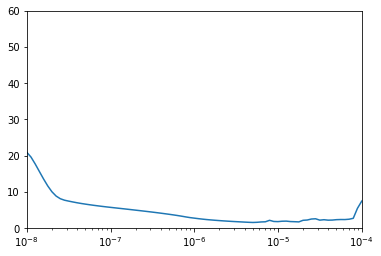

In [45]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [62]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5, strides=1, padding="causal", activation='relu', input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=6e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model.summary()
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1830      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [63]:
history = model.fit(train_set,epochs=150)

Epoch 1/150
30/30 [==============================] - 3s 14ms/step - loss: 15.8065 - mae: 16.2992
Epoch 2/150
30/30 [==============================] - 1s 16ms/step - loss: 2.8955 - mae: 3.3641
Epoch 3/150
30/30 [==============================] - 1s 16ms/step - loss: 2.1962 - mae: 2.6550
Epoch 4/150
30/30 [==============================] - 1s 17ms/step - loss: 2.0679 - mae: 2.5254
Epoch 5/150
30/30 [==============================] - 1s 16ms/step - loss: 2.0172 - mae: 2.4743
Epoch 6/150
30/30 [==============================] - 1s 16ms/step - loss: 1.9685 - mae: 2.4246
Epoch 7/150
30/30 [==============================] - 1s 18ms/step - loss: 1.9405 - mae: 2.3965
Epoch 8/150
30/30 [==============================] - 1s 17ms/step - loss: 1.9068 - mae: 2.3619
Epoch 9/150
30/30 [==============================] - 1s 17ms/step - loss: 1.8833 - mae: 2.3382
Epoch 10/150
30/30 [==============================] - 1s 18ms/step - loss: 1.8455 - mae: 2.2997
Epoch 11/150
30/30 [===========================

In [64]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

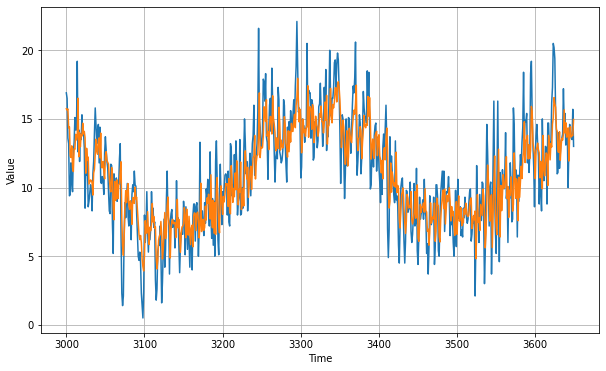

In [65]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [66]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7351258

In [67]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[15.73897   15.637406  15.725285  14.347826  14.417012  12.299996
 12.192863  13.037957  11.441925  11.170309  12.834748  12.788335
 13.880465  13.473145  13.761997  16.510912  12.240149  13.990214
 12.967274  13.843635  13.753539  14.689422  13.907349  14.093584
 13.631299  11.047441  12.861458  11.979135  12.223886  10.250086
 10.404433  10.557006  10.50109   10.343939   9.452696  11.067779
 11.3211975 12.467641  13.528313  12.640704  12.429311  13.426288
 13.620773  12.1636715 13.96908   11.459437  11.450556  11.89337
 11.15064   10.6293    12.309471  12.613954  11.969575  11.842753
 11.70619   10.711944   9.961242   9.686451  11.4635725 11.015017
  8.572526   7.652849  10.445216   9.066873   9.308983  10.559845
  9.189058  10.192792  10.276596  11.192582  11.877346   7.7381177
  5.7631383  5.061867   6.305585   8.585516   9.779292   8.904479
  9.676284  10.283979   8.702945   8.411269   9.035027   8.80359
  7.3243675  9.255514   9.268473   8.843451  10.025711   9.163605
  9.29285  